<a href="https://colab.research.google.com/github/PhilippShemetov/DetectAudio/blob/main/DetectAudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Первая лабораторная

##Подключение библиотек

In [3]:
import librosa
import math
import pandas as pd
import numpy as np
import scipy 
import scipy.fft
from scipy.fft import fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import re
import sklearn
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import FastICA

np.seterr(divide='raise', invalid='raise')

%matplotlib inline

##Скачиваем набор данных

In [ ]:
!wget https://drive.google.com/u/0/uc?id=1OXZ-7SKtOKZJh6ta1jOocd2ZPLWHRCTZ&export=download&confirm=t -P /content/gdrive/MyDrive/AudioDetect

In [ ]:
!sudo rm -rf /content/audioset_v1_embeddings/*

In [ ]:
!wget http://storage.googleapis.com/us_audioset/youtube_corpus/v1/features/features.tar.gz -P /content/gdrive/MyDrive/AudioDetect
!tar -xvzf /content/gdrive/MyDrive/AudioDetect/features.tar.gz

##Подключаем гугл диск

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Читаем набор данных c индексами звуков


In [ ]:
audio_set = pd.read_csv('/content/gdrive/MyDrive/AudioDetect/train.csv', skiprows = 1, header=None)
audio_set.columns = ['fname','label']

In [ ]:
audio_set

In [ ]:
wav,sr = librosa.load('/content/gdrive/MyDrive/AudioDetect/Gunshots.wav')

In [ ]:
def draw_waveform(wav, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()

draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

In [ ]:
def mel(spec):
    spec = 1125 * np.log(1 + spec/700)
    return spec

##STFT

In [ ]:
stft = librosa.stft(wav)
stft_ampl = abs(stft)
plt.figure(figsize=(15,10))
librosa.display.specshow(stft_ampl, sr=sr, x_axis='time', y_axis='hz')
print(stft_ampl)

##Разделяем на куски аудиозапись по 1 сек

In [ ]:
window_sec = len(wav) // sr
print(window_sec)
set_of_samples = []
mod_var = 0
for i in range(window_sec+1):
  if(sr *(i+1) // len(wav)):
    mod_var = sr * (i+1) % len(wav)
  set_of_samples.append(wav[sr*i:sr*(i+1) - mod_var])
print(len(set_of_samples))
#audio_labels = {"Speech":[set_of_samples[0],set_of_samples[1],set_of_samples[2],set_of_samples[3],
#                          set_of_samples[4],set_of_samples[5],set_of_samples[6],set_of_samples[7]],
#                "Noise":[set_of_samples[8],set_of_samples[9],
#                         set_of_samples[10],set_of_samples[11],set_of_samples[15]],
#                "Gunshot":[set_of_samples[12],set_of_samples[13],
#                         set_of_samples[14]]}
ipd.Audio(set_of_samples[6], rate=sr)

##Фурье преобразование и порог

In [ ]:

audio_energy = []
for sample in set_of_samples:
  stft_audio = abs(librosa.stft(sample))
  freq_lst = []
  audio_energy.append(sum(sum(stft_audio)))
print(audio_energy)

fig, ax = plt.subplots(nrows=1, sharex=True)
indexes = [i for i in range(len(audio_energy)) if audio_energy[i] > 40000]
print(indexes)
ax.plot(audio_energy) #выстрел

for i in range(len(set_of_samples)):
  if i not in indexes:
    set_of_samples[i] *= 0 

draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

##Вариант второй(WIP) не работает

In [ ]:
wav,sr = librosa.load('/content/gdrive/MyDrive/AudioDetect/Gunshots.wav')

In [ ]:
def draw_waveform(wav, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()

draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

In [ ]:
def mel(spec):
    spec = 1125 * np.log(1 + spec/700)
    return spec

In [ ]:
window_sec = len(wav) // sr
set_of_samples = []
mod_var = 0
for i in range(window_sec+1):
  if(sr *(i+1) // len(wav)):
    mod_var = sr * (i+1) % len(wav)
  set_of_samples.append(wav[sr*i:sr*(i+1) - mod_var])

##Future extraction
futures = [average, sum, max, min]

In [ ]:
audio_future = []
y_target = []
for sample in set_of_samples:
  stft_audio = abs(librosa.stft(sample))
  freq_lst = []
  audio_future.append([np.average(sum(stft_audio)),sum(sum(stft_audio)),max(sum(stft_audio)),min(sum(stft_audio))])
  if np.average(sum(stft_audio)) > 1000:
    y_target.append("Gunshot")
  else:
    y_target.append("Not Gunshot")
print(y_target)

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(audio_future,y_target, train_size=0.8,  random_state=42)

In [ ]:
print(y_train)

In [ ]:
svc = LinearSVC(C = 1000, tol=1e-5, max_iter=50000000)


In [ ]:
model = svc.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Лабораторная работа №1

##Формируем словарь звуков

In [5]:
audio_set = pd.read_csv('/content/gdrive/MyDrive/AudioDetect/train.csv', skiprows = 1, header=None)
audio_set.columns = ['fname','label']

In [6]:
audio_set
audio_dict = audio_set.set_index('fname').to_dict()['label']
audio_dict

{'8bcbcc394ba64fe85ed4.wav': 'Finger_snapping',
 '00d77b917e241afa06f1.wav': 'Squeak',
 '17bb93b73b8e79234cb3.wav': 'Electric_piano',
 '7d5c7a40a936136da55e.wav': 'Harmonica',
 '17e0ee7565a33d6c2326.wav': 'Snare_drum',
 '2d2900e792da5d4f6ab2.wav': 'Trumpet',
 '6464a45df1b76196be09.wav': 'Computer_keyboard',
 'b7c35da78543d5f73429.wav': 'Clarinet',
 '511d31f5a851cc0dae15.wav': 'Harmonica',
 '3496eb9b56346215e4d3.wav': 'Laughter',
 '54707f458de140781969.wav': 'Tearing',
 'a0ba703211ad22d66788.wav': 'Applause',
 'e36e70d42b9ec2dfc283.wav': 'Shatter',
 '58ee604efed7a592d864.wav': 'Computer_keyboard',
 '862e635c5ae0d9665122.wav': 'Clarinet',
 'b38486a89ff73a2da542.wav': 'Knock',
 'fd9a8ca19d270e28dae8.wav': 'Bass_drum',
 'f43d7d2212fb7203a234.wav': 'Cowbell',
 '5a9ae9490709ddb0a46f.wav': 'Squeak',
 '9d51b14bd8d26f9475b9.wav': 'Bass_drum',
 'b701ed703697a5fbef24.wav': 'Glockenspiel',
 'ae3b5de16b7a0a73e6bc.wav': 'Bass_drum',
 'f7fb5122abb091d9d6ba.wav': 'Shatter',
 'd59548e6179f98e2796b.wav'

In [7]:
wave_dict = {}
sr_dict = {}
list_of_files = sorted(glob('/content/gdrive/MyDrive/AudioDetect/train/*.wav'))
for path in list_of_files:
  index = re.search(r"\w+(\.wav)", path).group(0)
  wav,sr = librosa.load(path)
  audio_label = audio_dict[index]
  if audio_label not in wave_dict:
    wave_dict[audio_label] = [wav]
  else:
    wave_dict[audio_label].append(wav)
print(len(wave_dict))


41


In [9]:
wave_dict['Squeak'][0]
ipd.Audio(wave_dict['Meow'][1], rate=sr)

##Извлекаем MFCC признаки и применяем усреднение

In [10]:
X_data = []
y_data = []
for key,values in wave_dict.items():
  for value in values:
    X_data.append(librosa.feature.mfcc(value))
    y_data.append(key)

In [15]:
print(len(X_data))

5683


In [ ]:
X_data_feature = []
for data in X_data:
  X_data_feature.append(np.average(data,axis = 1))

In [ ]:
print(np.shape(X_data_feature))

(5683, 20)


##Разделяем на обучающуюся и тестовую выборку

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_data_feature, y_data, train_size=0.8,  random_state=42)

##Ищем оптимальные параметры

In [ ]:
svc = sklearn.svm.SVC()

In [ ]:
param = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
#              'kernel': ['linear']
#              'decision_function_shape':['ovo', 'ovr'] Требует много времени
        }

grid = sklearn.model_selection.GridSearchCV(svc, param, refit=True, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
model = svc.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.034 total time=   3.4s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.034 total time=   3.0s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.034 total time=   3.4s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.034 total time=   3.0s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.034 total time=   3.0s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.034 total time=   3.3s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.034 total time=   3.3s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.034 total time=   3.3s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.034 total time=   3.3s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.034 total time=   3.3s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.034 total time=   3.9s
[CV 2/5] END .................C=0.1, gamma=0.01

In [ ]:
svc_new = sklearn.svm.SVC(C = 10, gamma = 0.0001)
model = svc_new.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[13  0  0 ...  0  0  1]
 [ 0 22  0 ...  1  0  0]
 [ 1  0 12 ...  0  0  0]
 ...
 [ 0  2  0 ... 17  0  0]
 [ 1  1  0 ...  1 16  1]
 [ 2  0  1 ...  0  0 17]]
                       precision    recall  f1-score   support

      Acoustic_guitar       0.38      0.42      0.40        31
             Applause       0.63      0.79      0.70        28
                 Bark       0.40      0.63      0.49        19
            Bass_drum       0.68      0.78      0.72        32
Burping_or_eructation       0.79      0.60      0.68        25
                  Bus       0.42      0.62      0.50        13
                Cello       0.53      0.54      0.53        39
                Chime       0.64      0.47      0.55        19
             Clarinet       0.62      0.88      0.72        24
    Computer_keyboard       0.25      0.15      0.19        13
                Cough       0.44      0.38      0.41        40
              Cowbell       0.74      0.80      0.77        25
          Double_bass   

##Загружаем аудиозапись с выстрелом

In [ ]:
wav,sr = librosa.load('/content/gdrive/MyDrive/AudioDetect/Gunshots.wav')

##Разделяем клип по 1 секунде

In [ ]:
window_sec = len(wav) // sr
set_of_samples = []
mod_var = 0
for i in range(window_sec+1):
  if(sr *(i+1) // len(wav)):
    mod_var = sr * (i+1) % len(wav)
  set_of_samples.append(wav[sr*i:sr*(i+1) - mod_var])
print(np.shape(set_of_samples))


(16,)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


##Результат

In [ ]:
X_test2 = []
for i in set_of_samples:
  X_test2.append(np.average(librosa.feature.mfcc(value),axis = 1))

y_pred = model.predict(X_test2)
print(y_pred)

['Tearing' 'Tearing' 'Tearing' 'Tearing' 'Tearing' 'Tearing' 'Tearing'
 'Tearing' 'Tearing' 'Tearing' 'Tearing' 'Tearing' 'Tearing' 'Tearing'
 'Tearing' 'Tearing']


Вывод: На каждой сеунде аудиоклипа классификатор показывает, что происходит ивент "Разрыв". Ивент выстрела не был запредикчен. Нужно более точнее настроить параметры, подругому извлечь признаки и исследовать другие методы, так как момент выстрела не был найден

#Лабораторная Работа 2 - CNN

In [1]:
import librosa
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
import torchaudio
import torch.nn.functional as F
import torchaudio.transforms as T
import pandas as pd
import numpy as np
import scipy 
import scipy.fft
from sklearn import preprocessing
from IPython.display import Audio, display
from scipy.fft import fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import re
import sklearn
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import FastICA

np.seterr(divide='raise', invalid='raise')

%matplotlib inline

##Функции для получение информации о сигнале

In [2]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

def padding_to_wav(wav,pad_size,mode = 'None'):
  p = (pad_size - len(wav.flatten())) // 2 + 1
  if p>0:
    if mode is 'constant':
      wav = torch.nn.functional.pad(wav, (p, p), value=0.0)
    else:
      wav = torch.nn.functional.pad(wav, (p, p), mode='reflect')
  wav = wav[:, :pad_size]
  return wav

##Формируем словарь звуков

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
audio_set = pd.read_csv('/content/gdrive/MyDrive/AudioDetect/train.csv', skiprows = 1, header=None)
audio_set.columns = ['fname','label']

In [ ]:
audio_set
audio_dict = audio_set.set_index('fname').to_dict()['label']
audio_dict

In [6]:
wave_dict = {}
sr_dict = {}
len_sum = 0
count = 0
average_len_wav = 108929
list_of_files = sorted(glob('/content/gdrive/MyDrive/AudioDetect/train/*.wav'))
for path in list_of_files:
  index = re.search(r"\w+(\.wav)", path).group(0)
  wav,sr = torchaudio.load(path)
  wav = padding_to_wav(wav,average_len_wav,'constant')
  len_sum += len(wav[0])
  count += 1
  audio_label = audio_dict[index]
  if audio_label not in wave_dict:
    wave_dict[audio_label] = [wav]
  else:
    wave_dict[audio_label].append(wav)
n_classes = len(wave_dict)


In [172]:
print(average_len)

108929


In [7]:
#new_wave = padding_to_wav(wave_dict['Meow'][1],average_len,'constant')
#print(np.shape(new_wave))
#play_audio(new_wave,sr)
play_audio(wave_dict['Meow'][4],sr)
#ipd.Audio(wave_dict['Meow'][1], rate=sr)

##Настройка параметров для MFCC

torch.Size([256, 213])


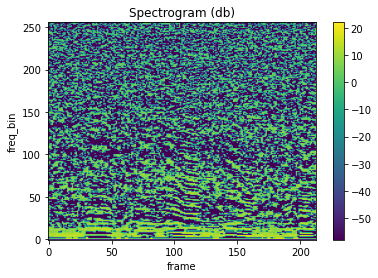

In [8]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sr,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(wave_dict['Meow'][1])
print(np.shape(mfcc[0]))
plot_spectrogram(mfcc[0])

##Извлекаем MFCC признаки

In [9]:
X_data = []
y_data = []
for key,values in wave_dict.items():
  for value in values:
    #print(np.shape(mfcc_transform(value)[0]))
    X_data.append(mfcc_transform(value))
    y_data.append(key)

In [135]:
X_data_tensor = torch.stack(X_data)
print(np.shape(X_data_tensor))
#print(y_data)
le = preprocessing.LabelEncoder()
y_labels = le.fit_transform(y_data)
y_labels = torch.as_tensor(y_labels)
#print(le.inverse_transform(y_labels))

torch.Size([5683, 1, 256, 213])


##Разделяем на обучающуюся и тестовую выборку

In [129]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_data_tensor,y_labels, train_size=0.8,  random_state=42)


train = data_utils.TensorDataset(X_train,y_train)
test = data_utils.TensorDataset(X_test,y_test)

train_set = DataLoader(train,batch_size=16,shuffle=True)
test_set = DataLoader(test,batch_size=16,shuffle=False)

##Строим нейронную сеть

In [130]:
class CNNet(nn.Module):
    def __init__(self, in_channels = 1,out_channels = 16,kernel_size = 5):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.pool1 = nn.MaxPool2d(2,2)
        self.drop1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3)
        self.pool2 = nn.MaxPool2d(2,2)
        self.drop2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(out_channels, 2 * out_channels, 3)
        self.bn3 = nn.BatchNorm2d(2 * out_channels)
        self.drop3 = nn.Dropout(0.2)
        self.pool3 = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(2 * out_channels, 2 * out_channels, 3)
        self.bn4 = nn.BatchNorm2d(2 * out_channels)
        self.drop4 = nn.Dropout(0.2)
        self.pool4 = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4928, 64)
        #self.drop3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 41)


    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = self.drop1(x)
        x = F.relu(self.pool2(self.conv2(x)))
        x = self.drop2(x)
        x = F.relu(self.pool3(self.conv3(x)))
        x = self.drop3(x)
        x = F.relu(self.pool4(self.conv4(x)))
        x = self.drop4(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x,dim=1)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNet().to(device)

##Выбираем параметры оптимизации

In [131]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

##Обучение нейронной сети

In [132]:
from tqdm import tqdm

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(train_set, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
    #print('loss:', sum(running_loss)/len(running_loss))

print('Finished Training')

55it [00:01, 33.57it/s]

[1,    50] loss: 3.695


103it [00:03, 34.30it/s]

[1,   100] loss: 3.612


155it [00:04, 32.71it/s]

[1,   150] loss: 3.558


203it [00:06, 29.93it/s]

[1,   200] loss: 3.500


255it [00:07, 33.98it/s]

[1,   250] loss: 3.413


285it [00:08, 32.38it/s]
56it [00:01, 33.09it/s]

[2,    50] loss: 3.424


104it [00:03, 30.18it/s]

[2,   100] loss: 3.366


156it [00:04, 32.77it/s]

[2,   150] loss: 3.297


204it [00:06, 33.89it/s]

[2,   200] loss: 3.262


256it [00:07, 33.96it/s]

[2,   250] loss: 3.183


285it [00:08, 32.00it/s]
56it [00:01, 31.19it/s]

[3,    50] loss: 3.038


104it [00:03, 34.14it/s]

[3,   100] loss: 3.011


154it [00:04, 25.68it/s]

[3,   150] loss: 2.955


206it [00:06, 34.05it/s]

[3,   200] loss: 3.016


254it [00:07, 29.51it/s]

[3,   250] loss: 2.916


285it [00:08, 32.01it/s]
55it [00:01, 34.38it/s]

[4,    50] loss: 2.848


103it [00:03, 34.13it/s]

[4,   100] loss: 2.823


157it [00:05, 31.72it/s]

[4,   150] loss: 2.814


201it [00:06, 30.36it/s]

[4,   200] loss: 2.665


254it [00:08, 33.78it/s]

[4,   250] loss: 2.645


285it [00:08, 31.71it/s]
52it [00:01, 34.04it/s]

[5,    50] loss: 2.577


104it [00:03, 30.92it/s]

[5,   100] loss: 2.607


156it [00:04, 33.93it/s]

[5,   150] loss: 2.576


203it [00:06, 33.00it/s]

[5,   200] loss: 2.434


255it [00:07, 34.52it/s]

[5,   250] loss: 2.474


285it [00:08, 33.02it/s]
56it [00:01, 30.48it/s]

[6,    50] loss: 2.473


104it [00:03, 27.72it/s]

[6,   100] loss: 2.421


155it [00:05, 31.60it/s]

[6,   150] loss: 2.309


203it [00:06, 30.04it/s]

[6,   200] loss: 2.265


254it [00:08, 30.96it/s]

[6,   250] loss: 2.201


285it [00:09, 31.16it/s]
56it [00:01, 33.12it/s]

[7,    50] loss: 2.228


104it [00:03, 34.57it/s]

[7,   100] loss: 2.228


152it [00:04, 33.73it/s]

[7,   150] loss: 2.162


203it [00:06, 31.89it/s]

[7,   200] loss: 2.159


254it [00:07, 34.21it/s]

[7,   250] loss: 2.220


285it [00:08, 31.96it/s]
56it [00:01, 32.17it/s]

[8,    50] loss: 2.048


103it [00:03, 32.92it/s]

[8,   100] loss: 1.968


155it [00:04, 34.38it/s]

[8,   150] loss: 1.998


203it [00:06, 33.52it/s]

[8,   200] loss: 1.930


255it [00:07, 33.90it/s]

[8,   250] loss: 2.028


285it [00:08, 32.01it/s]
54it [00:01, 29.72it/s]

[9,    50] loss: 1.962


106it [00:03, 34.17it/s]

[9,   100] loss: 1.910


154it [00:04, 30.78it/s]

[9,   150] loss: 1.974


205it [00:06, 28.50it/s]

[9,   200] loss: 1.808


256it [00:08, 30.78it/s]

[9,   250] loss: 1.790


285it [00:09, 31.36it/s]
56it [00:01, 30.89it/s]

[10,    50] loss: 1.742


104it [00:03, 28.21it/s]

[10,   100] loss: 1.734


156it [00:04, 32.16it/s]

[10,   150] loss: 1.867


204it [00:06, 34.48it/s]

[10,   200] loss: 1.770


256it [00:07, 30.64it/s]

[10,   250] loss: 1.824


285it [00:08, 32.02it/s]
56it [00:01, 30.08it/s]

[11,    50] loss: 1.601


103it [00:03, 28.77it/s]

[11,   100] loss: 1.685


154it [00:04, 31.11it/s]

[11,   150] loss: 1.645


206it [00:06, 34.50it/s]

[11,   200] loss: 1.761


254it [00:07, 34.05it/s]

[11,   250] loss: 1.631


285it [00:08, 31.93it/s]
55it [00:01, 34.38it/s]

[12,    50] loss: 1.671


107it [00:03, 33.54it/s]

[12,   100] loss: 1.565


155it [00:04, 34.11it/s]

[12,   150] loss: 1.602


203it [00:06, 33.60it/s]

[12,   200] loss: 1.729


255it [00:07, 29.73it/s]

[12,   250] loss: 1.586


285it [00:08, 32.56it/s]
52it [00:01, 29.81it/s]

[13,    50] loss: 1.479


104it [00:03, 28.16it/s]

[13,   100] loss: 1.545


156it [00:04, 33.23it/s]

[13,   150] loss: 1.448


203it [00:06, 29.36it/s]

[13,   200] loss: 1.501


255it [00:07, 34.44it/s]

[13,   250] loss: 1.621


285it [00:08, 32.59it/s]
56it [00:01, 34.26it/s]

[14,    50] loss: 1.435


104it [00:03, 28.94it/s]

[14,   100] loss: 1.336


153it [00:04, 32.75it/s]

[14,   150] loss: 1.461


205it [00:06, 33.92it/s]

[14,   200] loss: 1.542


253it [00:07, 31.33it/s]

[14,   250] loss: 1.361


285it [00:08, 31.95it/s]
55it [00:01, 28.32it/s]

[15,    50] loss: 1.327


103it [00:03, 33.50it/s]

[15,   100] loss: 1.337


155it [00:04, 33.46it/s]

[15,   150] loss: 1.258


203it [00:06, 28.79it/s]

[15,   200] loss: 1.405


254it [00:08, 31.32it/s]

[15,   250] loss: 1.412


285it [00:09, 31.59it/s]
55it [00:01, 29.90it/s]

[16,    50] loss: 1.190


106it [00:03, 33.25it/s]

[16,   100] loss: 1.287


153it [00:05, 27.61it/s]

[16,   150] loss: 1.239


204it [00:06, 34.61it/s]

[16,   200] loss: 1.278


256it [00:08, 33.94it/s]

[16,   250] loss: 1.316


285it [00:08, 32.04it/s]
56it [00:01, 34.42it/s]

[17,    50] loss: 1.329


104it [00:03, 34.44it/s]

[17,   100] loss: 1.215


156it [00:04, 34.51it/s]

[17,   150] loss: 1.256


204it [00:06, 30.56it/s]

[17,   200] loss: 1.250


256it [00:07, 33.99it/s]

[17,   250] loss: 1.344


285it [00:08, 32.77it/s]
56it [00:01, 33.49it/s]

[18,    50] loss: 1.140


104it [00:03, 34.12it/s]

[18,   100] loss: 1.154


156it [00:04, 32.75it/s]

[18,   150] loss: 1.211


203it [00:06, 34.11it/s]

[18,   200] loss: 1.286


255it [00:07, 31.32it/s]

[18,   250] loss: 1.183


285it [00:08, 32.30it/s]
53it [00:01, 30.61it/s]

[19,    50] loss: 1.046


105it [00:03, 33.84it/s]

[19,   100] loss: 1.138


153it [00:04, 28.42it/s]

[19,   150] loss: 1.133


204it [00:06, 33.66it/s]

[19,   200] loss: 1.145


256it [00:07, 34.27it/s]

[19,   250] loss: 1.218


285it [00:08, 32.31it/s]
55it [00:01, 32.14it/s]

[20,    50] loss: 1.156


103it [00:03, 34.28it/s]

[20,   100] loss: 1.042


155it [00:04, 31.90it/s]

[20,   150] loss: 1.069


205it [00:06, 32.61it/s]

[20,   200] loss: 1.188


253it [00:07, 34.03it/s]

[20,   250] loss: 1.062


285it [00:08, 32.22it/s]
52it [00:01, 33.95it/s]

[21,    50] loss: 1.035


104it [00:03, 28.36it/s]

[21,   100] loss: 1.034


152it [00:04, 30.84it/s]

[21,   150] loss: 1.124


206it [00:06, 30.14it/s]

[21,   200] loss: 1.038


254it [00:08, 33.40it/s]

[21,   250] loss: 1.119


285it [00:09, 31.63it/s]
55it [00:01, 31.10it/s]

[22,    50] loss: 0.846


101it [00:03, 32.51it/s]

[22,   100] loss: 1.021


153it [00:05, 28.60it/s]

[22,   150] loss: 0.937


205it [00:06, 28.10it/s]

[22,   200] loss: 0.984


253it [00:08, 34.59it/s]

[22,   250] loss: 1.069


285it [00:09, 31.06it/s]
56it [00:01, 33.72it/s]

[23,    50] loss: 0.969


103it [00:03, 30.72it/s]

[23,   100] loss: 0.944


155it [00:04, 33.82it/s]

[23,   150] loss: 0.977


205it [00:06, 33.73it/s]

[23,   200] loss: 0.984


253it [00:08, 32.45it/s]

[23,   250] loss: 0.978


285it [00:09, 31.55it/s]
55it [00:01, 33.82it/s]

[24,    50] loss: 0.903


103it [00:03, 32.56it/s]

[24,   100] loss: 0.903


155it [00:04, 33.20it/s]

[24,   150] loss: 0.924


207it [00:06, 33.42it/s]

[24,   200] loss: 0.886


255it [00:08, 33.83it/s]

[24,   250] loss: 0.966


285it [00:09, 31.61it/s]
56it [00:01, 34.55it/s]

[25,    50] loss: 0.775


104it [00:03, 32.00it/s]

[25,   100] loss: 0.823


156it [00:04, 31.86it/s]

[25,   150] loss: 0.816


204it [00:06, 33.85it/s]

[25,   200] loss: 0.803


256it [00:07, 31.88it/s]

[25,   250] loss: 0.969


285it [00:08, 32.41it/s]
56it [00:01, 32.61it/s]

[26,    50] loss: 0.728


104it [00:03, 28.56it/s]

[26,   100] loss: 0.785


155it [00:04, 30.00it/s]

[26,   150] loss: 0.852


203it [00:06, 28.65it/s]

[26,   200] loss: 0.878


255it [00:07, 34.46it/s]

[26,   250] loss: 0.871


285it [00:08, 32.22it/s]
52it [00:01, 32.22it/s]

[27,    50] loss: 0.652


103it [00:03, 31.38it/s]

[27,   100] loss: 0.750


155it [00:04, 34.14it/s]

[27,   150] loss: 0.769


206it [00:06, 32.32it/s]

[27,   200] loss: 0.828


254it [00:08, 33.27it/s]

[27,   250] loss: 0.740


285it [00:09, 31.66it/s]
56it [00:01, 31.70it/s]

[28,    50] loss: 0.814


104it [00:03, 31.11it/s]

[28,   100] loss: 0.776


152it [00:04, 34.43it/s]

[28,   150] loss: 0.806


204it [00:06, 32.23it/s]

[28,   200] loss: 0.739


256it [00:07, 30.94it/s]

[28,   250] loss: 0.749


285it [00:08, 32.69it/s]
54it [00:01, 30.94it/s]

[29,    50] loss: 0.674


102it [00:03, 34.20it/s]

[29,   100] loss: 0.706


156it [00:04, 28.03it/s]

[29,   150] loss: 0.768


204it [00:06, 34.03it/s]

[29,   200] loss: 0.682


256it [00:08, 31.02it/s]

[29,   250] loss: 0.823


285it [00:08, 32.03it/s]
52it [00:01, 31.30it/s]

[30,    50] loss: 0.595


104it [00:03, 33.00it/s]

[30,   100] loss: 0.650


155it [00:04, 34.15it/s]

[30,   150] loss: 0.633


203it [00:06, 33.78it/s]

[30,   200] loss: 0.654


254it [00:07, 31.95it/s]

[30,   250] loss: 0.713


285it [00:08, 31.87it/s]
54it [00:01, 31.68it/s]

[31,    50] loss: 0.626


104it [00:03, 33.01it/s]

[31,   100] loss: 0.644


156it [00:05, 33.98it/s]

[31,   150] loss: 0.603


204it [00:06, 34.22it/s]

[31,   200] loss: 0.628


254it [00:08, 28.70it/s]

[31,   250] loss: 0.683


285it [00:09, 31.23it/s]
55it [00:01, 29.47it/s]

[32,    50] loss: 0.587


103it [00:03, 30.93it/s]

[32,   100] loss: 0.668


155it [00:04, 34.61it/s]

[32,   150] loss: 0.718


203it [00:06, 32.95it/s]

[32,   200] loss: 0.641


255it [00:07, 31.76it/s]

[32,   250] loss: 0.546


285it [00:08, 32.28it/s]
51it [00:01, 33.35it/s]

[33,    50] loss: 0.504


107it [00:03, 30.59it/s]

[33,   100] loss: 0.505


155it [00:04, 30.67it/s]

[33,   150] loss: 0.505


203it [00:06, 34.12it/s]

[33,   200] loss: 0.505


251it [00:07, 31.82it/s]

[33,   250] loss: 0.626


285it [00:08, 31.96it/s]
56it [00:01, 34.03it/s]

[34,    50] loss: 0.496


104it [00:03, 34.17it/s]

[34,   100] loss: 0.549


156it [00:04, 30.93it/s]

[34,   150] loss: 0.494


204it [00:06, 30.79it/s]

[34,   200] loss: 0.614


254it [00:07, 33.32it/s]

[34,   250] loss: 0.681


285it [00:08, 31.69it/s]
52it [00:01, 29.02it/s]

[35,    50] loss: 0.524


105it [00:03, 33.12it/s]

[35,   100] loss: 0.450


153it [00:04, 34.68it/s]

[35,   150] loss: 0.554


205it [00:06, 28.91it/s]

[35,   200] loss: 0.606


256it [00:08, 34.15it/s]

[35,   250] loss: 0.624


285it [00:09, 31.63it/s]
55it [00:01, 32.72it/s]

[36,    50] loss: 0.511


103it [00:03, 29.06it/s]

[36,   100] loss: 0.491


154it [00:04, 28.67it/s]

[36,   150] loss: 0.518


206it [00:06, 34.36it/s]

[36,   200] loss: 0.485


254it [00:07, 33.97it/s]

[36,   250] loss: 0.594


285it [00:08, 32.78it/s]
55it [00:01, 33.04it/s]

[37,    50] loss: 0.412


103it [00:03, 28.26it/s]

[37,   100] loss: 0.501


155it [00:04, 31.33it/s]

[37,   150] loss: 0.443


203it [00:06, 32.13it/s]

[37,   200] loss: 0.494


251it [00:07, 29.70it/s]

[37,   250] loss: 0.517


285it [00:08, 32.02it/s]
55it [00:01, 33.91it/s]

[38,    50] loss: 0.503


107it [00:03, 33.11it/s]

[38,   100] loss: 0.469


155it [00:04, 33.08it/s]

[38,   150] loss: 0.464


203it [00:06, 29.58it/s]

[38,   200] loss: 0.445


255it [00:07, 33.98it/s]

[38,   250] loss: 0.526


285it [00:08, 32.62it/s]
56it [00:01, 32.27it/s]

[39,    50] loss: 0.517


104it [00:03, 34.61it/s]

[39,   100] loss: 0.345


152it [00:04, 33.48it/s]

[39,   150] loss: 0.440


204it [00:06, 28.69it/s]

[39,   200] loss: 0.498


255it [00:07, 34.18it/s]

[39,   250] loss: 0.500


285it [00:08, 32.67it/s]
56it [00:01, 34.12it/s]

[40,    50] loss: 0.452


104it [00:03, 27.00it/s]

[40,   100] loss: 0.376


156it [00:04, 34.18it/s]

[40,   150] loss: 0.369


204it [00:06, 28.99it/s]

[40,   200] loss: 0.429


255it [00:07, 30.08it/s]

[40,   250] loss: 0.473


285it [00:08, 32.35it/s]
55it [00:01, 31.79it/s]

[41,    50] loss: 0.347


106it [00:03, 32.85it/s]

[41,   100] loss: 0.395


153it [00:04, 34.37it/s]

[41,   150] loss: 0.357


205it [00:06, 31.47it/s]

[41,   200] loss: 0.459


257it [00:07, 34.60it/s]

[41,   250] loss: 0.476


285it [00:08, 32.49it/s]
56it [00:01, 29.95it/s]

[42,    50] loss: 0.406


104it [00:03, 34.24it/s]

[42,   100] loss: 0.399


156it [00:04, 30.57it/s]

[42,   150] loss: 0.354


204it [00:06, 30.53it/s]

[42,   200] loss: 0.421


255it [00:08, 29.93it/s]

[42,   250] loss: 0.522


285it [00:08, 31.67it/s]
56it [00:01, 30.69it/s]

[43,    50] loss: 0.359


103it [00:03, 33.86it/s]

[43,   100] loss: 0.371


155it [00:04, 30.72it/s]

[43,   150] loss: 0.327


207it [00:06, 33.78it/s]

[43,   200] loss: 0.478


255it [00:08, 30.02it/s]

[43,   250] loss: 0.388


285it [00:09, 31.59it/s]
55it [00:01, 33.96it/s]

[44,    50] loss: 0.323


103it [00:03, 34.65it/s]

[44,   100] loss: 0.367


155it [00:04, 32.61it/s]

[44,   150] loss: 0.384


203it [00:06, 27.81it/s]

[44,   200] loss: 0.405


253it [00:07, 27.37it/s]

[44,   250] loss: 0.363


285it [00:09, 31.65it/s]
56it [00:01, 33.83it/s]

[45,    50] loss: 0.298


104it [00:03, 33.81it/s]

[45,   100] loss: 0.378


156it [00:04, 34.13it/s]

[45,   150] loss: 0.294


204it [00:06, 34.46it/s]

[45,   200] loss: 0.338


255it [00:07, 32.04it/s]

[45,   250] loss: 0.460


285it [00:08, 32.41it/s]
55it [00:01, 33.27it/s]

[46,    50] loss: 0.446


103it [00:03, 34.48it/s]

[46,   100] loss: 0.397


155it [00:04, 32.38it/s]

[46,   150] loss: 0.349


203it [00:06, 30.29it/s]

[46,   200] loss: 0.383


255it [00:07, 29.80it/s]

[46,   250] loss: 0.366


285it [00:08, 32.60it/s]
56it [00:01, 31.69it/s]

[47,    50] loss: 0.324


104it [00:03, 33.63it/s]

[47,   100] loss: 0.354


152it [00:04, 29.66it/s]

[47,   150] loss: 0.442


204it [00:06, 28.83it/s]

[47,   200] loss: 0.277


252it [00:07, 34.14it/s]

[47,   250] loss: 0.349


285it [00:08, 32.53it/s]
54it [00:01, 34.63it/s]

[48,    50] loss: 0.300


106it [00:03, 34.64it/s]

[48,   100] loss: 0.304


153it [00:04, 28.13it/s]

[48,   150] loss: 0.354


205it [00:06, 32.25it/s]

[48,   200] loss: 0.386


257it [00:08, 31.27it/s]

[48,   250] loss: 0.416


285it [00:08, 31.94it/s]
56it [00:01, 34.13it/s]

[49,    50] loss: 0.301


104it [00:03, 34.11it/s]

[49,   100] loss: 0.311


155it [00:04, 33.23it/s]

[49,   150] loss: 0.319


203it [00:06, 30.00it/s]

[49,   200] loss: 0.420


255it [00:07, 34.34it/s]

[49,   250] loss: 0.408


285it [00:08, 32.35it/s]
55it [00:01, 34.34it/s]

[50,    50] loss: 0.260


103it [00:03, 30.27it/s]

[50,   100] loss: 0.296


155it [00:04, 32.77it/s]

[50,   150] loss: 0.247


203it [00:06, 34.49it/s]

[50,   200] loss: 0.344


255it [00:07, 32.78it/s]

[50,   250] loss: 0.320


285it [00:08, 32.15it/s]

Finished Training


In [133]:
y_pred = []
model.eval()
with torch.no_grad():
  for inputs,target in test_set:
    inputs = inputs.to(device)
    output = model(inputs)
    for idx, i in enumerate(output):
      y_pred.append(torch.argmax(i).item())

In [134]:
print(y_test)
print(classification_report(y_test.numpy(), y_pred))
f1 = sklearn.metrics.f1_score(y_test, y_pred, average='macro')
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred, average='macro')
recall = sklearn.metrics.recall_score(y_test, y_pred, average='macro')
print('metrics:', 'acc:',acc,'f1:',f1,'prec:',precision,'recall:',recall)

tensor([25, 11, 39,  ..., 33, 12,  6])
              precision    recall  f1-score   support

           0       0.59      0.42      0.49        31
           1       0.81      0.61      0.69        28
           2       0.50      0.53      0.51        19
           3       0.74      0.62      0.68        32
           4       0.81      0.68      0.74        25
           5       0.50      0.23      0.32        13
           6       0.58      0.54      0.56        39
           7       0.65      0.68      0.67        19
           8       0.45      0.83      0.59        24
           9       0.18      0.15      0.17        13
          10       0.42      0.42      0.42        40
          11       0.90      0.76      0.83        25
          12       0.86      0.83      0.84        46
          13       0.11      0.30      0.16        10
          14       0.42      0.57      0.48        14
          15       0.52      0.61      0.56        38
          16       0.44      0.44      0.4

###Результат экспериментов

####Набор данных:
* Длительность каждой записи: 6 сек (Была посчитана средняя продолжительность всех аудиозаписей и использован метод padding, где по краям были добавлены нулевые значения)
* Признаки: MFCC Features
* Размерность: [5683, 1, 256, 213]


####**Эксперимент №1**:
*   Оптимизация: SGD(lr=0.001, momentum=0.9)
*   Эпох: 25
*   Batch-size: 16
*   Коэф. Dropout: 0.2
*   MaxPool размер: 2
*   Количество сверточных/полносвязных слоев: 2x Conv2d, 2x Full Layer

Результаты эксперимента:
*  loss function: 3.86 -> 0.268
*  accuracity: 0.41, f1-score: 0.38

####**Эксперимент №2**:
*   Оптимизация: SGD
*   Эпох: 50
*   Batch-size: 16
*   Коэф. Dropout: 0.2
*   MaxPool размер: 2
*   Количество сверточных/полносвязных слоев: 2x Conv2d, 2x Full Layer

Результаты эксперимента:
*  loss function: 3.876 -> 0.039
*  accuracity: 0.42, f1-score: 0.39

####**Эксперимент №3**:
*   Оптимизация: SGD
*   Эпох: 100
*   Batch-size: 16
*   Коэф. Dropout: 0.2
*   MaxPool размер: 2
*   Количество сверточных/полносвязных слоев: 2x Conv2d, 2x Full Layer

Результаты эксперимента:
*  loss function: 3.67 -> 0.077
*  accuracity: 0.33, f1-score: 0.30

####**Эксперимент №4**:
*   Оптимизация: SGD
*   Эпох: 25
*   Batch-size: 32
*   Коэф. Dropout: 0.2
*   MaxPool размер: 2
*   Количество сверточных/полносвязных слоев: 2x Conv2d, 2x Full Layer

Результаты эксперимента:
*  loss function: 3.570 -> 0.117
*  accuracity: 0.50, f1-score: 0.47

####**Эксперимент №5**:
*   Оптимизация: SGD
*   Эпох: 50
*   Batch-size: 32
*   Коэф. Dropout: 0.2
*   MaxPool размер: 2
*   Количество сверточных/полносвязных слоев: 2x Conv2d, 2x Full Layer

Результаты эксперимента:
*  loss function: 3.584 -> 0.108
*  accuracity: 0.46, f1-score: 0.43

####**Эксперимент №6**:
*   Оптимизация: SGD
*   Эпох: 25
*   Batch-size: 64
*   Коэф. Dropout: 0.2
*   MaxPool размер: 2
*   Количество сверточных/полносвязных слоев: 2x Conv2d, 2x Full Layer

Результаты эксперимента:
*  loss function: 4.116 -> 0.071
*  accuracity: 0.50, f1-score: 0.47

###Как видим, для дальнейшего эксперимента оптимальнее взять параметры эксперимента №4

####**Эксперимент №7**:
*   Оптимизация:ADAM(lr=0.001, weight_decay=0.0001)
*   Эпох: 25
*   Batch-size: 32
*   Коэф. Dropout: 0.2
*   MaxPool размер: 2
*   Количество сверточных/полносвязных слоев: 2x Conv2d, 2x Full Layer

Результаты эксперимента:
*  loss function: 3.984 -> 1.245
*  accuracity: 0.26, f1-score: 0.21

###Оптимизация Adam ухудшает результат, следующие эксперименты будут связаны с добавлением полных/сверточных слоёв. Для всех прошлых экспериментов. 

####**Эксперимент №8**:
*   Оптимизация: SGD
*   Эпох: 25
*   Batch-size: 16
*   Коэф. Dropout: 0.2
*   MaxPool размер: 2
*   Количество сверточных/полносвязных слоев: 3x Conv2d, 2x Full Layer

Результаты эксперимента:
*  loss function: 3.674 -> 0.593
*  accuracity: 0.46, f1-score: 0.44

####**Эксперимент №9**:
*   Оптимизация: SGD
*   Эпох: 50
*   Batch-size: 16
*   Коэф. Dropout: 0.2
*   MaxPool размер: 2
*   Количество сверточных/полносвязных слоев: 3x Conv2d, 2x Full Layer

Результаты эксперимента:
*  loss function: 3.662 -> 0.094
*  accuracity: 0.50, f1-score: 0.46

####**Эксперимент №10**:
*   Оптимизация: SGD
*   Эпох: 25
*   Batch-size: 32
*   Коэф. Dropout: 0.2
*   MaxPool размер: 2
*   Количество сверточных/полносвязных слоев: 3x Conv2d, 2x Full Layer

Результаты эксперимента:
*  loss function: 3.569 -> 0.569
*  accuracity: 0.50, f1-score: 0.43

####**Эксперимент №11**:
*   Оптимизация: SGD
*   Эпох: 50
*   Batch-size: 32
*   Коэф. Dropout: 0.2
*   MaxPool размер: 2
*   Количество сверточных/полносвязных слоев: 3x Conv2d, 2x Full Layer

Результаты эксперимента:
*  loss function: 3.517 -> 0.185
*  accuracity: 0.57, f1-score: 0.52

####**Эксперимент №12**:
*   Оптимизация: SGD
*   Эпох: 25
*   Batch-size: 64
*   Коэф. Dropout: 0.2
*   MaxPool размер: 2
*   Количество сверточных/полносвязных слоев: 3x Conv2d, 2x Full Layer

Результаты эксперимента:
*  loss function: 3.634 -> 1.218
*  accuracity: 0.49, f1-score: 0.43

###Добавляем четвертый сверточный слой

####**Эксперимент №13**:
*   Оптимизация: SGD
*   Эпох: 25
*   Batch-size: 16
*   Коэф. Dropout: 0.2
*   MaxPool размер: 2
*   Количество сверточных/полносвязных слоев: 4x Conv2d, 2x Full Layer

Результаты эксперимента:
*  loss function: 3.816 -> 1.024
*  accuracity: 0.54, f1-score: 0.50

####**Эксперимент №14**:
*   Оптимизация: SGD
*   Эпох: 50
*   Batch-size: 16
*   Коэф. Dropout: 0.2
*   MaxPool размер: 2
*   Количество сверточных/полносвязных слоев: 4x Conv2d, 2x Full Layer

Результаты эксперимента:
*  loss function: 3.695 -> 0.320
*  accuracity: 0.54, f1-score: 0.50

###Эксперименты в процессе, на данный момент, самая лучшая точность - 0.57





In [ ]:
wav,sr = librosa.load('/content/gdrive/MyDrive/AudioDetect/Gunshots.wav')

In [ ]:
window_sec = len(wav) // sr
set_of_samples = []
mod_var = 0
for i in range(window_sec+1):
  if(sr *(i+1) // len(wav)):
    mod_var = sr * (i+1) % len(wav)
  set_of_samples.append(wav[sr*i:sr*(i+1) - mod_var])
print(np.shape(set_of_samples))

In [ ]:
X_test2 = []
for i in set_of_samples:
  X_test2.append(np.average(librosa.feature.mfcc(value),axis = 1))

y_pred = model.predict(X_test2)
print(y_pred)